In [1]:
import torch
import torchvision
from torchvision import datasets, transforms

In [2]:
pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
print(torch.__version__)

2.4.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from PIL import Image
import os

In [6]:
dataset_path = '/kaggle/input/tumor-trace-data'

In [7]:
from torch.utils.data import Dataset

**loading custom dataset**

In [8]:
class BreastCancerDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = self._load_samples()
        print(f"Number of samples found: {len(self.samples)}")
        if len(self.samples) == 0:
            raise ValueError(f"No valid samples found in {self.dataset_path}")

    def _load_samples(self):
        samples = []
        for label in ['Benign', 'Malignant']:
            label_dir = os.path.join(self.dataset_path, label)
            if not os.path.exists(label_dir):
                continue
            for root, _, files in os.walk(label_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        file_path = os.path.join(root, file)
                        samples.append((file_path, 0 if label == 'Benign' else 1))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
from torch.utils.data import Dataset, DataLoader

# Define the transform

transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

])



# Create the dataset and dataloader for each split (train, test, val)

train_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



test_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



val_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/val', transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



# Example: Iterate through the train_loader to see some batches

for images, labels in train_loader:

    print(images.size(), labels)  # Print the size of the batch and the labels

    break  # Just show the first batch


Number of samples found: 20434
Number of samples found: 6851
Number of samples found: 1989
torch.Size([32, 3, 224, 224]) tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])


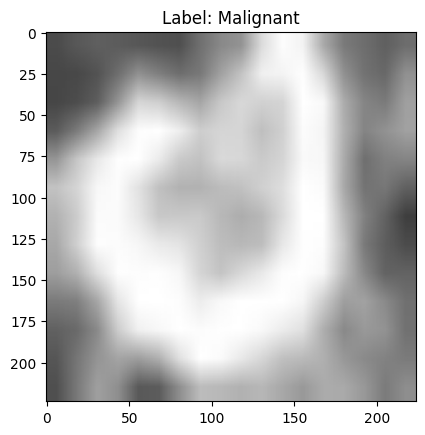

In [10]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
image = images[3]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.title(f"Label: {'Benign' if labels[0] == 0 else 'Malignant'}")
plt.show()


Train Set: Benign = 5559, Malignant = 14875
Test Set: Benign = 1938, Malignant = 4913
Validation Set: Benign = 408, Malignant = 1581


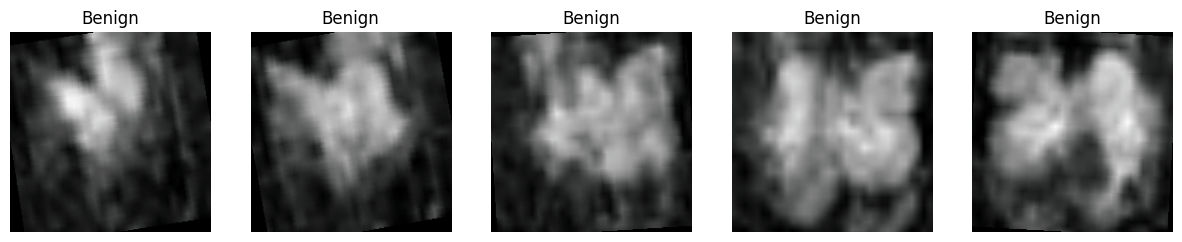

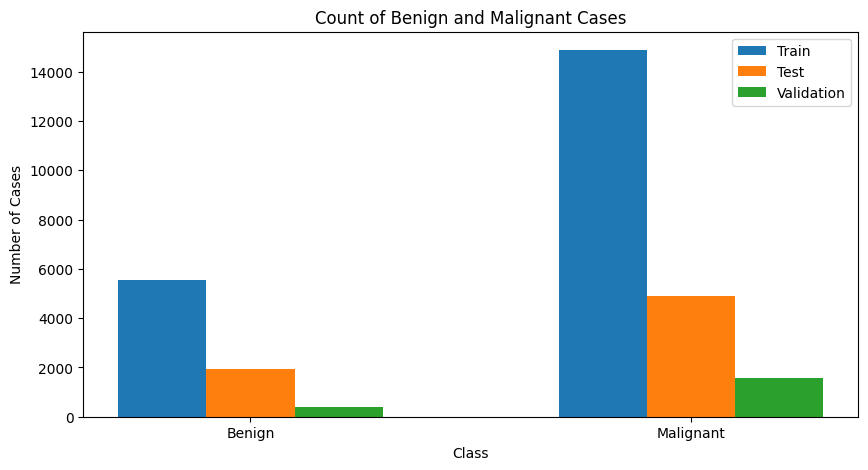

In [11]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the dataset path (update as per your dataset in Kaggle)
dataset_path = "/kaggle/input/tumor-trace-data/clasification-roi"  # Adjust this to match your Kaggle dataset path

# Define transformations for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(210),  # Randomly crop images to 210x210
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.RandomRotation(15),  # Random rotation
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Define transformations for validation and test datasets
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=test_transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=valid_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Count classes in datasets
benign_count_train = train_dataset.targets.count(0)
malignant_count_train = train_dataset.targets.count(1)
print(f'Train Set: Benign = {benign_count_train}, Malignant = {malignant_count_train}')

benign_count_test = test_dataset.targets.count(0)
malignant_count_test = test_dataset.targets.count(1)
print(f'Test Set: Benign = {benign_count_test}, Malignant = {malignant_count_test}')

benign_count_valid = valid_dataset.targets.count(0)
malignant_count_valid = valid_dataset.targets.count(1)
print(f'Validation Set: Benign = {benign_count_valid}, Malignant = {malignant_count_valid}')

# Function to display sample images
def display_sample_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        # Reverse the normalization for display purposes
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
        image = (image * 255).astype('uint8')  # Convert to 8-bit integer format for display
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(dataset.classes[label])
        plt.axis('off')
    plt.show()

# Display sample images from the training dataset
display_sample_images(train_dataset)

# Plot class distributions
labels = ['Benign', 'Malignant']
train_counts = [benign_count_train, malignant_count_train]
test_counts = [benign_count_test, malignant_count_test]
valid_counts = [benign_count_valid, malignant_count_valid]

x = range(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, train_counts, width=0.2, label='Train', align='center')
plt.bar([p + 0.2 for p in x], test_counts, width=0.2, label='Test', align='center')
plt.bar([p + 0.4 for p in x], valid_counts, width=0.2, label='Validation', align='center')

plt.xlabel('Class')
plt.ylabel('Number of Cases')
plt.title('Count of Benign and Malignant Cases')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.show()


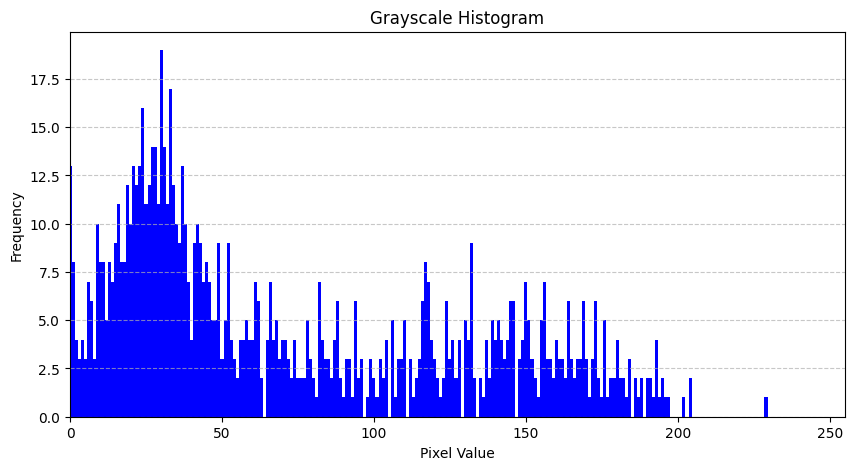

Top 5 Most Frequent Pixel Values and Their Frequencies:
Pixel Value: 30, Frequency: 19
Pixel Value: 33, Frequency: 17
Pixel Value: 24, Frequency: 16
Pixel Value: 27, Frequency: 14
Pixel Value: 28, Frequency: 14


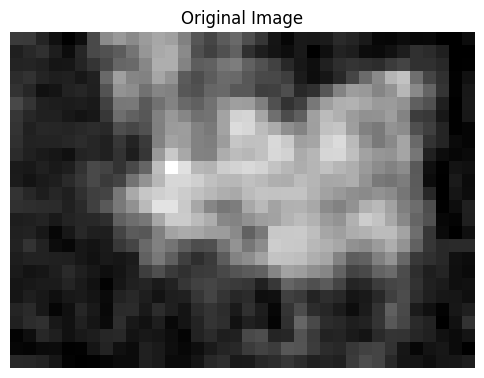

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the image path in the Kaggle input directory
image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1801/SUB1/p-034.jpg'

# Load the image in grayscale mode
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Could not load image from path: {image_path}")
else:
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    # Get the top N most frequent pixel values
    top_n = 5
    most_frequent_indices = np.argsort(hist)[-top_n:][::-1]

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(range(256), hist, color='blue', width=1.0)
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xlim([0, 255])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Print the most frequent pixel values and their frequencies
    print("Top 5 Most Frequent Pixel Values and Their Frequencies:")
    for idx in most_frequent_indices:
        print(f"Pixel Value: {idx}, Frequency: {int(hist[idx])}")

    # Visualize the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()


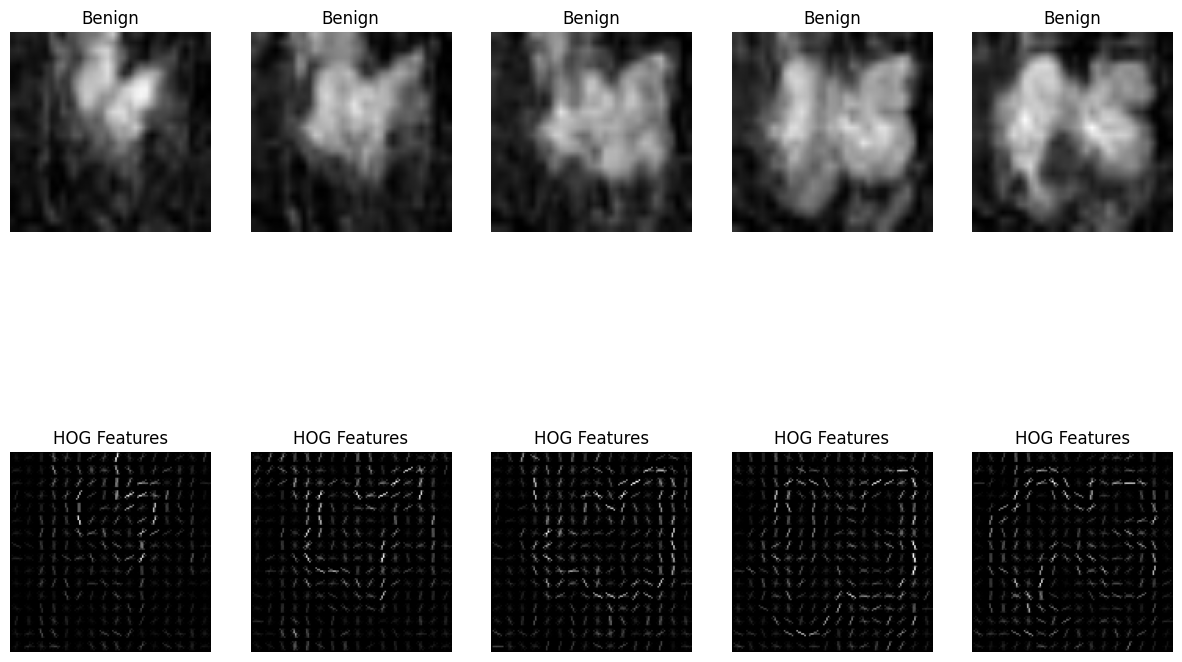

In [13]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.feature import hog
from skimage import color
import matplotlib.pyplot as plt
import numpy as np

# Define the dataset path in Kaggle
dataset_path = "/kaggle/input/tumor-trace-data/clasification-roi"  # Adjust this to match your Kaggle dataset

# Define transformations for resizing images (HOG operates on fixed-size images)
resize_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # HOG works well with smaller images
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=resize_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=resize_transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=resize_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Function to extract HOG features from a dataset image
def extract_hog_features(image):
    image_np = image.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
    image_gray = color.rgb2gray(image_np)  # Convert RGB image to grayscale
    hog_features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True, feature_vector=True)
    return hog_features, hog_image

# Display HOG features for sample images
def display_hog_sample(dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image, label = dataset[i]
        hog_features, hog_image = extract_hog_features(image)
        
        # Plot the original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # Original image
        plt.title(dataset.classes[label])
        plt.axis('off')

        # Plot the HOG visualization
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(hog_image, cmap='gray')  # HOG visualization
        plt.title('HOG Features')
        plt.axis('off')
    plt.show()

# Example of HOG features for training images
display_hog_sample(train_dataset)


**EDA**

In [14]:
from skimage import color, exposure
from skimage.feature import hog, corner_harris, corner_peaks
from skimage import color, exposure
from skimage.feature import hog, corner_harris, corner_peaks 

** histogram of pixel values**

Calculate GLCM properties

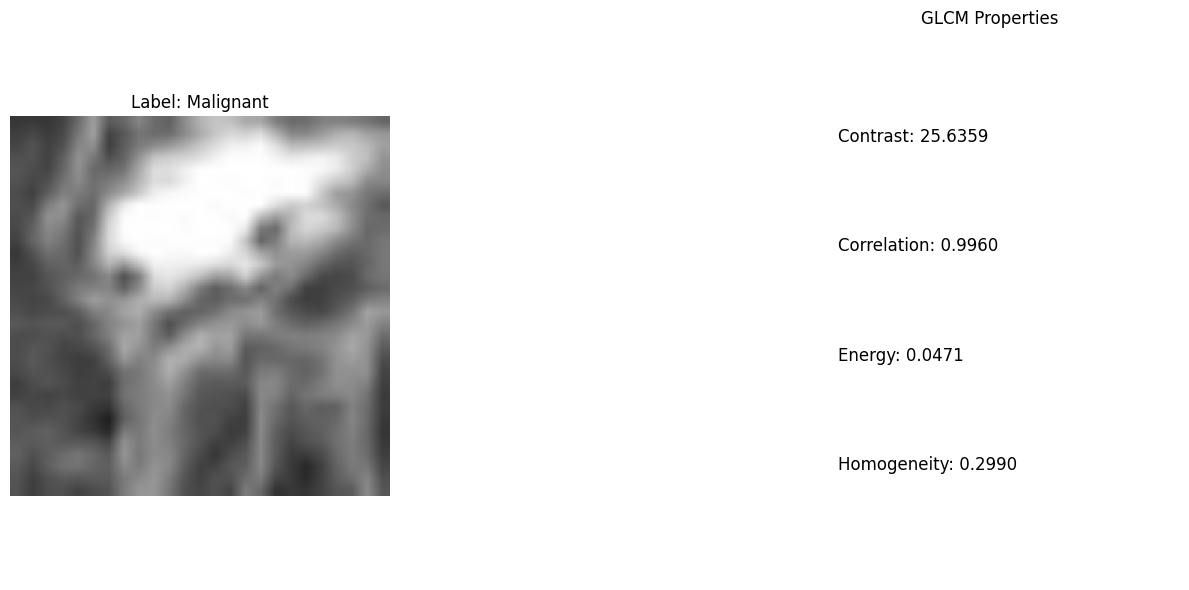

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import torch

# Get a batch of images and labels from train_loader
images, labels = next(iter(train_loader))

# Select the first image from the batch
image = images[0]

# Convert the image from a PyTorch tensor to a NumPy array and grayscale it
image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format and ensure it's on CPU
gray_image = rgb2gray(image)  # Convert RGB image to grayscale

# Plot the original image and GLCM properties
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f"Label: {'Benign' if labels[0].item() == 0 else 'Malignant'}")
plt.axis('off')

# Calculate GLCM and GLCM properties
distances = [1]  # Pixel pair distance
angles = [0]  # Angle (0 degrees)
glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=distances, angles=angles, symmetric=True, normed=True)

# Extract GLCM properties
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

# Display GLCM properties
plt.subplot(1, 3, 3)
plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=12)
plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=12)
plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=12)
plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=12)
plt.axis('off')
plt.title("GLCM Properties")

plt.tight_layout()
plt.show()


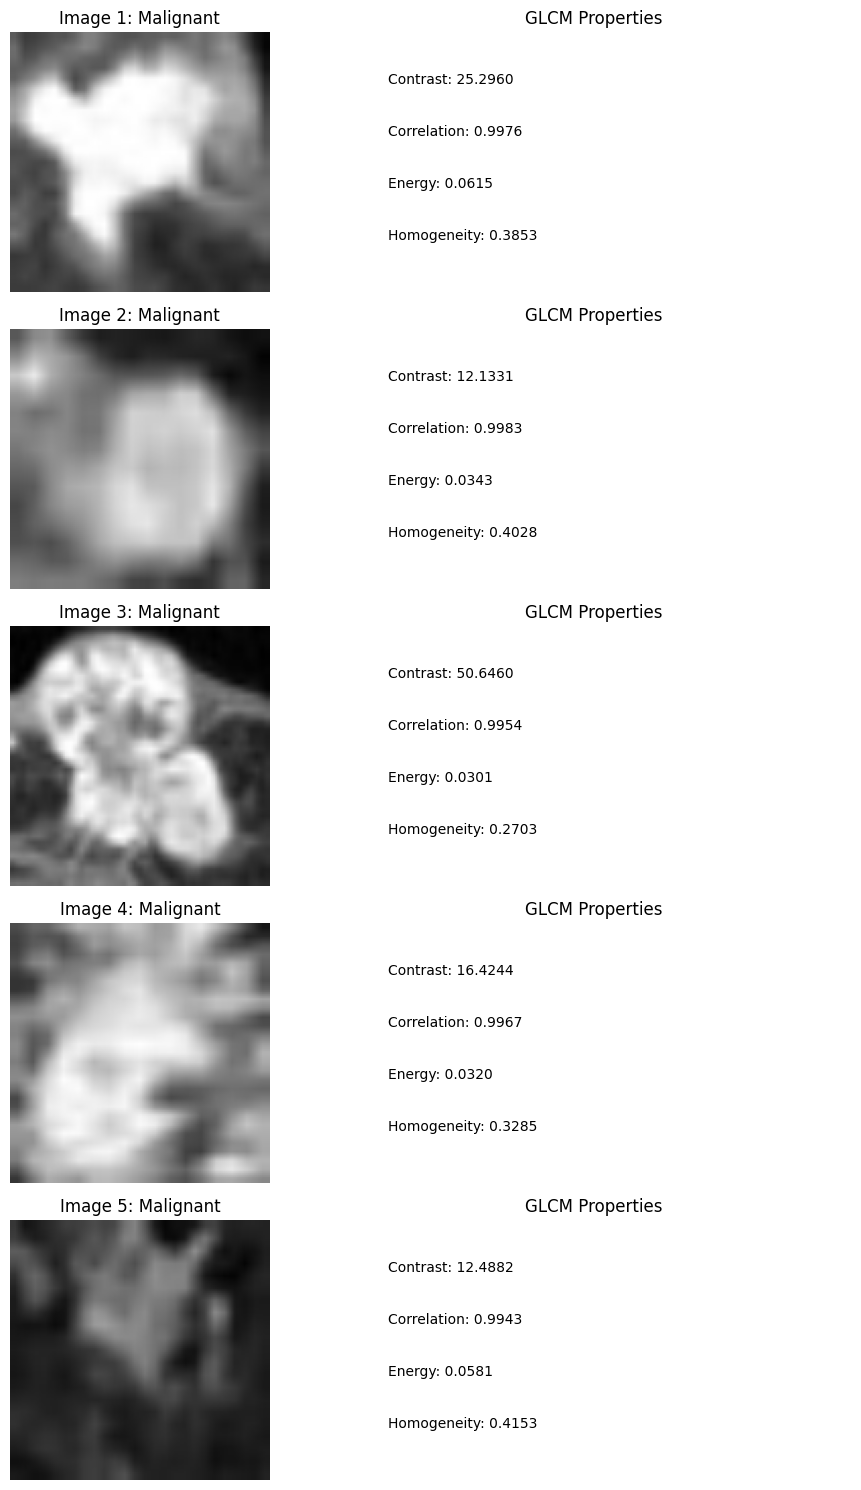

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import torch

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Define parameters for GLCM calculation
distances = [1]  # Pixel pair distance
angles = [0]  # Angle (0 degrees)

# Number of images to process
num_images = 5

# Plot the images and their GLCM properties
plt.figure(figsize=(10, num_images * 3))

for idx in range(num_images):
    # Select the image and label
    image = images[idx]
    label = labels[idx].item()

    # Convert the image from a PyTorch tensor to a NumPy array and grayscale it
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format
    gray_image = rgb2gray(image)  # Convert RGB image to grayscale

    # Calculate GLCM and GLCM properties
    glcm = graycomatrix(
        (gray_image * 255).astype(np.uint8), 
        distances=distances, 
        angles=angles, 
        symmetric=True, 
        normed=True
    )
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Plot the image
    plt.subplot(num_images, 2, idx * 2 + 1)
    plt.imshow(image)
    plt.title(f"Image {idx+1}: {'Benign' if label == 0 else 'Malignant'}")
    plt.axis('off')

    # Plot the GLCM properties
    plt.subplot(num_images, 2, idx * 2 + 2)
    plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=10)
    plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=10)
    plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=10)
    plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=10)
    plt.axis('off')
    plt.title("GLCM Properties")

plt.tight_layout()
plt.show()


 HOG image for visualization

coner dectection




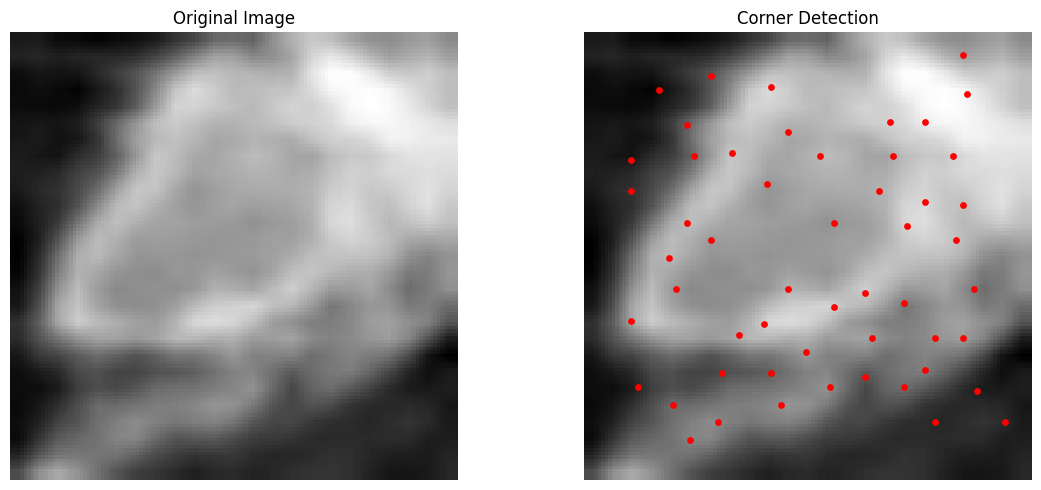

Number of corners detected: 53


In [17]:
from skimage.feature import corner_harris, corner_peaks  # Importing corner detection functions
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# Get a batch of images and labels from the DataLoader
images, labels = next(iter(train_loader))

# Select a specific image and its label
image = images[5]  # Selecting the 6th image (index 5)
image = image.permute(1, 2, 0).cpu().numpy()  # Convert tensor to HxWxC format and ensure it's on CPU
gray_image = rgb2gray(image)  # Convert RGB image to grayscale

# Perform Harris corner detection
corners = corner_harris(gray_image)

# Perform corner peak detection
coords = corner_peaks(corners, min_distance=5)

# Plot the original image and the detected corners
plt.figure(figsize=(12, 5))

# Original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Image with detected corners
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=15, c='red', marker='o')
plt.title('Corner Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display the number of corners detected
print(f'Number of corners detected: {len(coords)}')


Sobel operator

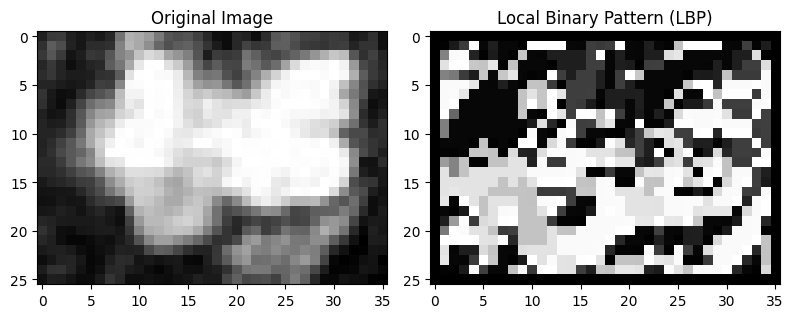

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def local_binary_pattern(image, radius=1, neighbors=8):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)
    angle_step = 2 * np.pi / neighbors

    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            center_pixel = image[i, j]
            lbp_code = 0

            for n in range(neighbors):
                y = int(i + radius * np.sin(n * angle_step))
                x = int(j + radius * np.cos(n * angle_step))
                if image[y, x] >= center_pixel:
                    lbp_code |= 1 << n

            lbp_image[i, j] = lbp_code

    return lbp_image

# Define the input image path in the Kaggle input directory
input_image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1801/SUB6/p-035.jpg'

# Read the image in grayscale
image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {input_image_path}. Please check the file path.")

# Calculate the LBP
lbp_image = local_binary_pattern(image)

# Display the original and LBP images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')

plt.tight_layout()
plt.show()


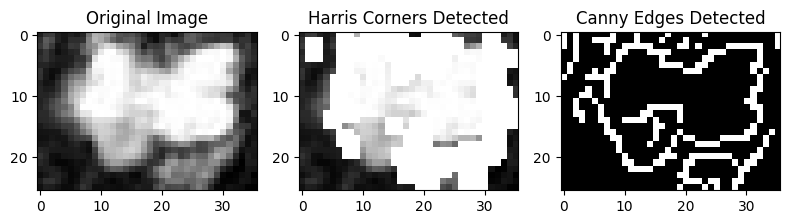

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def harris_corner_detection(image, block_size=2, ksize=3, k=0.04):
    gray_image = np.float32(image)
    harris_response = cv2.cornerHarris(gray_image, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)
    corners_image = image.copy()
    corners_image[harris_response > 0.01 * harris_response.max()] = 255
    return corners_image

def canny_edge_detection(image, lower_threshold=100, upper_threshold=200):
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    return edges

# Define the input image path in the Kaggle input directory
input_image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1801/SUB6/p-035.jpg'

# Read the image in grayscale
image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {input_image_path}. Please check the file path.")

# Apply Harris corner detection
corners_image = harris_corner_detection(image)

# Apply Canny edge detection
edges_image = canny_edge_detection(image)

# Convert images for display in Jupyter Notebook
corners_image_rgb = cv2.cvtColor(corners_image, cv2.COLOR_GRAY2RGB)
edges_image_rgb = cv2.cvtColor(edges_image, cv2.COLOR_GRAY2RGB)

# Display the images using Matplotlib
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(corners_image_rgb)
plt.title('Harris Corners Detected')

plt.subplot(1, 3, 3)
plt.imshow(edges_image_rgb)
plt.title('Canny Edges Detected')

plt.tight_layout()
plt.show()


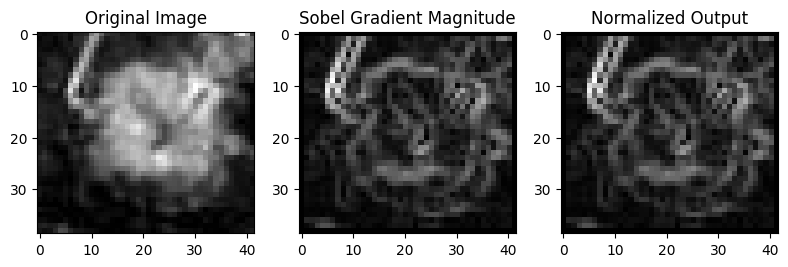

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define Sobel kernels
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0,  0,  0], [1,  2,  1]])

# Function to apply convolution between image and kernel
def apply_convolution(image, kernel):
    height, width = image.shape
    kernel_height, kernel_width = kernel.shape
    output_image = np.zeros((height, width))
    for i in range(1, height-1):
        for j in range(1, width-1):
            region = image[i-1:i+2, j-1:j+2]  # 3x3 region around the pixel
            output_image[i, j] = np.sum(region * kernel)
    return output_image

# Function to compute gradient magnitude from Sobel outputs
def compute_gradient_magnitude(sobel_x_output, sobel_y_output):
    return np.sqrt(sobel_x_output**2 + sobel_y_output**2)

# Function to normalize the image for display
def normalize_image(image):
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) / (image_max - image_min) * 255
    return normalized_image.astype(np.uint8)

# Define the input image path in Kaggle
input_image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Malignant/BreaDM-Ma-1802/SUB1/p-035.jpg'

# Load the image
image = Image.open(input_image_path).convert('L')  # Convert to grayscale

# Convert the image to a NumPy array
image_array = np.array(image)

# Apply Sobel operators
sobel_x_output = apply_convolution(image_array, sobel_x)
sobel_y_output = apply_convolution(image_array, sobel_y)

# Calculate gradient magnitude (Sobel magnitude)
sobel_magnitude = compute_gradient_magnitude(sobel_x_output, sobel_y_output)

# Normalize the output image for better visualization
normalized_output = normalize_image(sobel_magnitude)

# Display the results
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(sobel_magnitude, cmap='gray')
plt.title('Sobel Gradient Magnitude')

plt.subplot(1, 3, 3)
plt.imshow(normalized_output, cmap='gray')
plt.title('Normalized Output')

plt.tight_layout()
plt.show()


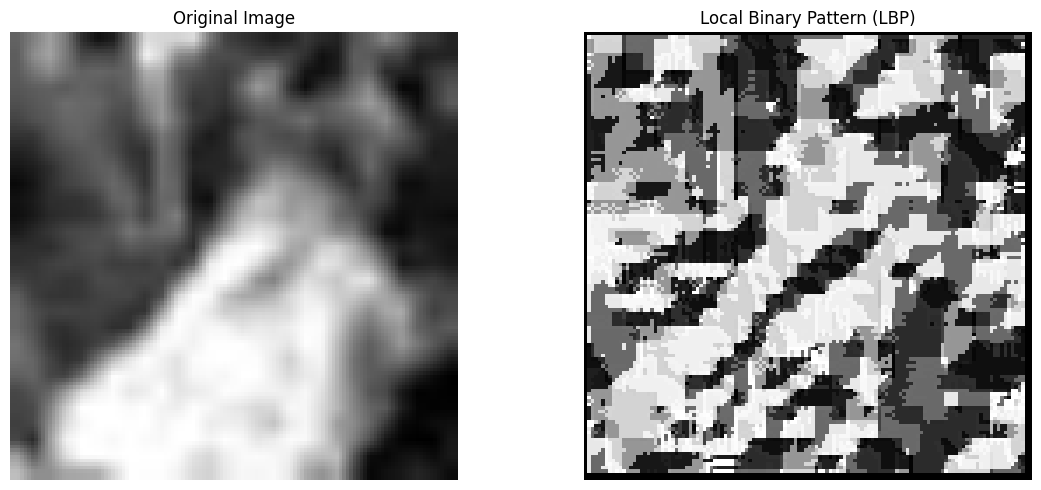

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def lbp_scratch(image):
    """
    Computes the Local Binary Pattern (LBP) for an input image from scratch.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Ensure the image is in grayscale
    imgLBP = np.zeros_like(gray_image)  # Initialize the LBP image

    neighboor = 3  # Define the size of the neighborhood (3x3 window)

    # Iterate over each pixel in the grayscale image, excluding the border pixels
    for ih in range(0, gray_image.shape[0] - neighboor):
        for iw in range(0, gray_image.shape[1] - neighboor):
            # Extract a 3x3 region centered on the current pixel
            img = gray_image[ih:ih + neighboor, iw:iw + neighboor]
            center = img[1, 1]  # The center pixel value of the 3x3 region

            # Binary operation - Compare each neighbor's value with the center pixel
            img01 = (img >= center) * 1.0  # Threshold the 3x3 region

            # Flatten the thresholded image into a vector, excluding the center pixel
            img01_vector = img01.flatten()
            img01_vector = np.delete(img01_vector, 4)  # Remove the center pixel

            # Convert the binary pattern to a decimal number
            where_img01_vector = np.where(img01_vector)[0]  # Indices where the value is 1
            if len(where_img01_vector) >= 1:
                num = np.sum(2 ** where_img01_vector)  # Convert binary to decimal
            else:
                num = 0  # If all surrounding pixels are smaller, assign 0

            # Assign the LBP value to the central pixel of the output image
            imgLBP[ih + 1, iw + 1] = num

    return imgLBP

# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Select an image from the batch (ensure it's properly sized)
image = images[4].numpy().transpose((1, 2, 0))

# Compute LBP using the custom function
lbp_image = lbp_scratch(image)

# Display the original and LBP images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')

plt.tight_layout()
plt.show()


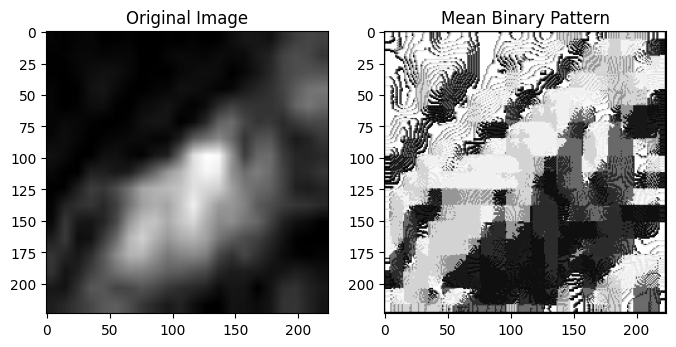

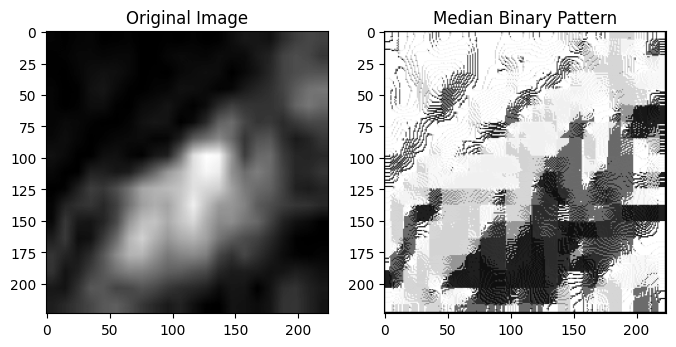

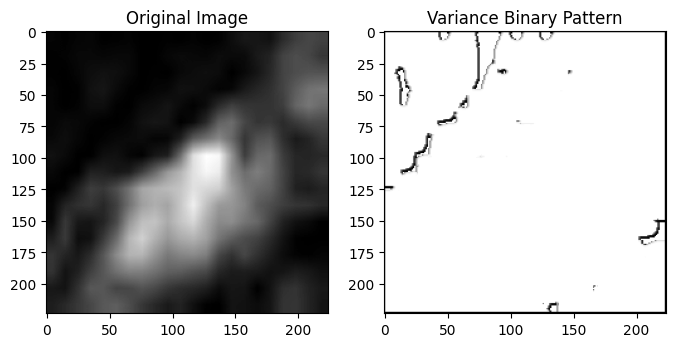

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def binary_pattern(image_path, method='mean'):
    try:
        # Load the image in grayscale
        img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_array is None:
            raise FileNotFoundError(f"Image at {image_path} not found.")
        
        img_array = cv2.resize(img_array, (224, 224))

        # Get the dimensions of the image
        rows, cols = img_array.shape

        # Initialize the output image
        bp_image = np.zeros((rows, cols), dtype=np.uint8)

        # Loop over the image, skipping the border pixels
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                # Extract the 3x3 neighborhood
                surr = img_array[i-1:i+2, j-1:j+2]

                # Calculate the reference value based on the selected method
                if method == 'mean':
                    ref_val = np.mean(surr)
                elif method == 'median':
                    ref_val = np.median(surr)
                elif method == 'variance':
                    ref_val = np.var(surr)
                else:
                    raise ValueError("Invalid method! Use 'mean', 'median', or 'variance'.")

                # Initialize the binary pattern
                binary_pattern = 0

                # Create the binary pattern by comparing neighbors to the reference value
                for ind, (dy, dx) in enumerate([(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]):
                    if surr[1 + dy, 1 + dx] >= ref_val:
                        binary_pattern += 2 ** ind

                # Set the binary pattern value for the current pixel
                bp_image[i, j] = binary_pattern

        # Normalize the output image for display
        bp_image_normalized = cv2.normalize(bp_image, None, 0, 255, cv2.NORM_MINMAX)

        # Display the original and binary pattern images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array, cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(bp_image_normalized, cmap='gray')
        plt.title(f'{method.capitalize()} Binary Pattern')

        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1812/SUB1/p-025.jpg'
binary_pattern(image_path, method='mean')     # For Mean Binary Pattern
binary_pattern(image_path, method='median')   # For Median Binary Pattern
binary_pattern(image_path, method='variance') # For Variance Binary Pattern


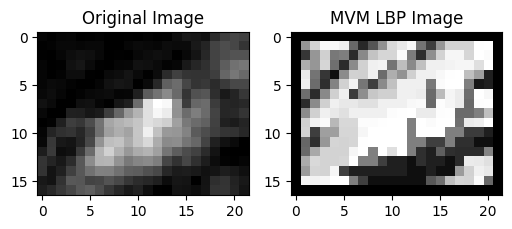

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mvm_lbp(gray_image):
    """
    Computes the Local Binary Pattern (LBP) using the Mean-Variance-Median (MVM) threshold.
    """
    rows, cols = gray_image.shape
    imgLBP = np.zeros((rows, cols), dtype=np.uint8)

    for ih in range(1, rows - 1):
        for iw in range(1, cols - 1):
            # Get the 3x3 neighborhood
            img = gray_image[ih-1:ih+2, iw-1:iw+2]

            # Calculate Mean, Variance, and Median
            mean_value = np.mean(img)
            variance_value = np.var(img)
            median_value = np.median(img)

            # Calculate MVM threshold
            mvm_threshold = (mean_value + np.sqrt(variance_value) + median_value) / 3

            # Create a binary pattern by thresholding with MVM threshold
            img01 = (img >= mvm_threshold).astype(int)

            # Flatten the binary pattern and exclude the center pixel
            img01_vector = np.delete(img01.flatten(), 4)

            # Convert the binary pattern to a decimal number
            num = np.dot(img01_vector, 2 ** np.arange(8))

            # Assign the LBP value to the output image
            imgLBP[ih, iw] = num

    return imgLBP

# Define the input image path in Kaggle
image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1812/SUB1/p-025.jpg'

# Read the grayscale image
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if gray_image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Compute the MVM LBP
lbp_image = mvm_lbp(gray_image)

# Display the original and LBP images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('MVM LBP Image')

plt.show()


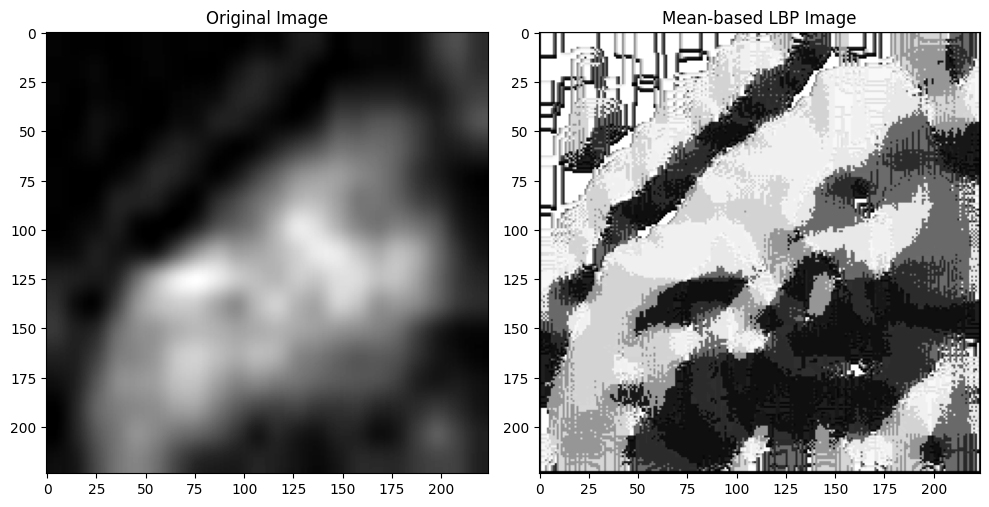

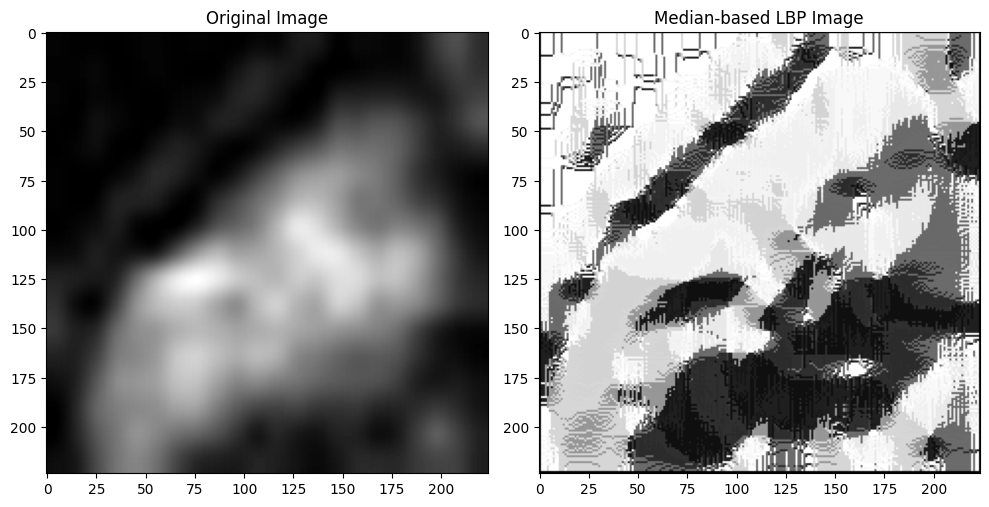

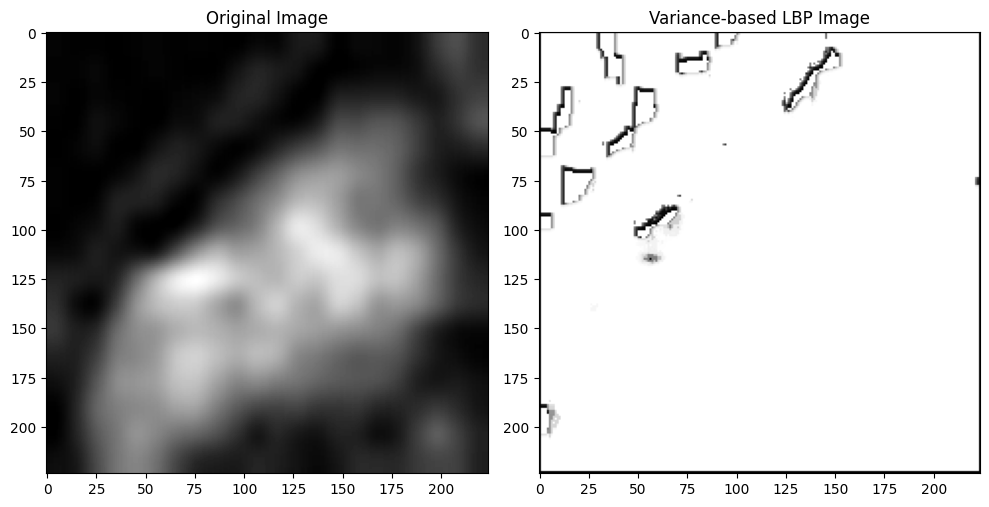

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Mean-based LBP calculation
def mean_based_lbp(image_array):
    rows, cols = image_array.shape
    lbp_image = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            neighborhood = image_array[i-1:i+2, j-1:j+2]
            mean_value = np.mean(neighborhood)
            surrounding_pixels = np.delete(neighborhood.flatten(), 4)
            binary_pattern = (surrounding_pixels >= mean_value).astype(int)
            lbp_image[i, j] = (binary_pattern * (2 ** np.arange(8))).sum()

    return lbp_image

# Median-based LBP calculation
def median_based_lbp(image_array):
    rows, cols = image_array.shape
    lbp_image = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            neighborhood = image_array[i-1:i+2, j-1:j+2]
            median_value = np.median(neighborhood)
            surrounding_pixels = np.delete(neighborhood.flatten(), 4)
            binary_pattern = (surrounding_pixels >= median_value).astype(int)
            lbp_image[i, j] = (binary_pattern * (2 ** np.arange(8))).sum()

    return lbp_image

# Variance-based LBP calculation
def variance_based_lbp(image_array):
    rows, cols = image_array.shape
    lbp_image = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            neighborhood = image_array[i-1:i+2, j-1:j+2]
            variance_value = np.var(neighborhood)
            surrounding_pixels = np.delete(neighborhood.flatten(), 4)
            binary_pattern = (surrounding_pixels >= variance_value).astype(int)
            lbp_image[i, j] = (binary_pattern * (2 ** np.arange(8))).sum()

    return lbp_image

# Display function to visualize the results
def display_results(original_image, lbp_image, title):
    lbp_image_normalized = (lbp_image / lbp_image.max()) * 255
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(lbp_image_normalized, cmap='gray')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Load and process image for each LBP method
image_path = '/kaggle/input/tumor-trace-data/clasification-roi/train/Benign/BreaDM-Be-1812/SUB1/p-026.jpg'  # Kaggle dataset path
original_image = Image.open(image_path).convert('L').resize((224, 224))
original_image_array = np.array(original_image)

# Mean-based LBP
mean_lbp_image = mean_based_lbp(original_image_array)
display_results(original_image_array, mean_lbp_image, 'Mean-based LBP Image')

# Median-based LBP
median_lbp_image = median_based_lbp(original_image_array)
display_results(original_image_array, median_lbp_image, 'Median-based LBP Image')

# Variance-based LBP
variance_lbp_image = variance_based_lbp(original_image_array)
display_results(original_image_array, variance_lbp_image, 'Variance-based LBP Image')


In [25]:
from torchvision import transforms

# Define transformations for the train, test, and validation datasets
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),    # Random horizontal flip
    transforms.RandomRotation(degrees=15),     # Random rotation
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), # Random resized crop
    transforms.ToTensor(),                     # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(224),                    # Resize the shorter edge to 224 pixels
    transforms.CenterCrop(224),                # Center crop to 224x224
    transforms.ToTensor(),                     # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize(224),                    # Resize the shorter edge to 224 pixels
    transforms.CenterCrop(224),                # Center crop to 224x224
    transforms.ToTensor(),                     # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])


In [26]:
from torch.utils.data import DataLoader


In [27]:
train_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/train', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = BreastCancerDataset('/kaggle/input/tumor-trace-data/clasification-roi/val', transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Example: Iterate through the train_loader to see some batches
for images, labels in train_loader:
    print(f"Batch size: {images.size()}")  # Prints the size of the batch
    print(f"Labels: {labels}")  # Prints the labels for the batch
    break  # Display only the first batch

Number of samples found: 20434
Number of samples found: 6851
Number of samples found: 1989
Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1])


In [28]:
import torch
import torchvision.models as models

# For ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Set the model to evaluation mode
print("ResNet18 Model:")
print(resnet18)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.7MB/s]


ResNet18 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [29]:
import torch

import torch.nn as nn

import torchvision.models as models

class Resnet18(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=True)
        self.conv1 = model_resnet18.conv1  # convolutional function
        self.bn1 = model_resnet18.bn1  # batch normalization
        self.relu = model_resnet18.relu  # relu is your activation function.
        self.maxpool = model_resnet18.maxpool  # maxpool is basically taking the biggest value per
        
        # sub_matrix
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4  # these layers are used for deepening the layers in the architecture which will increase
        
        self.avgpool = model_resnet18.avgpool
        self.features = model_resnet18.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [30]:
model = Resnet18()

print(model)

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [31]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.features = model_resnet50.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [32]:
model = Resnet50()

print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

**Model training**

In [33]:
import torch
import torch.nn as nn
import torchvision.models as models

class customVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(customVGG16, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract features and avgpool layers
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Linear layer with input size 512 7 7 and output size 4096
            nn.ReLU(),                    # ReLU activation function
            nn.Dropout(),                 # Dropout
            nn.Linear(4096, 4096),        # Another linear layer with input size 4096 and output size 4096
            nn.ReLU(),                    # ReLU activation
            nn.Dropout(),                 # Dropout layer
            nn.Linear(4096, num_classes)  # Final Linear layer with output size equal to number of classes
        )

    # Forward Method (Make sure this is outside the __init__ method)
    def forward(self, x):
        # Pass input through the features layer
        x = self.features(x)
        # Pass through the AVGpool layer
        x = self.avgpool(x)
        # Reshape output to a 2D tensor
        x = torch.flatten(x, 1)
        # Pass through the classifier
        x = self.classifier(x)
        return x


In [34]:
model = customVGG16()

print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s]


customVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [35]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        # Initialize best_score if not set, and check for improvement
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


training the VGG16 model

In [36]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from tqdm import tqdm

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [38]:
import torch
import torch.nn.functional as F
#from tqdm import tqdm #already imported in previous cell
import torch.optim as optim
#from tqdm import tqdm  #already imported in previous cell

# Get the CPU device

#device = torch.device("cpu")

#print(f"Using device: {device}")

# ... rest of your code using 'device' for tensors ...

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

train function

In [40]:
import torch
from tqdm import tqdm
import torch.nn.functional as F

epoch = 0

total_epochs = 50

loader = train_loader  # Ensure this is a DataLoader instance for training data

criterion = nn.CrossEntropyLoss()

l2_decay = 0.01

lr = 0.01  # Learning rate



def train(epoch, model, num_epochs, loader, criterion, l2_decay):

    learing_rate = max(lr*(0.1**(epoch//10)),1e-5)
    optimizer = torch.optim.SGD(model.parameters(), lr= learing_rate, momentum=0.9, weight_decay=l2_decay)

    model.train()

    correct = 0
    for data, label in tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        data = data.float().cuda()

        label = label.long().cuda()

        output = model(data)
        optimizer.zero_grad()
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    print(f'train accuracy: {100. * correct / len(loader.dataset)}%')



In [41]:
from sklearn.metrics import roc_curve, auc as compute_auc  # Rename the imported 'auc' function
import sklearn.metrics as metrics

def validation(model, val_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []  # Store all predictions
    all_targets = []  # Store all targets
    possibilities = None  # Store probabilities for AUC

    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        val_output = model(data)

        # Calculate test loss
        test_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()

        # Get predictions and accumulate them
        pred = val_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect all predictions
        all_targets.extend(target.cpu().numpy())  # Collect all target labels

        # Calculate probabilities for AUC
        possibility = F.softmax(val_output, dim=1).cpu().detach().numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        # Calculate the number of correct predictions
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[np.array(all_targets).astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_score = compute_auc(fpr, tpr)  # Use 'compute_auc' to avoid conflicts

    # Average test loss per sample
    test_loss /= len(val_loader.dataset)

    # Calculate specificity and sensitivity
    specificity = 1 - fpr[1] if len(fpr) > 1 else 0
    sensitivity = tpr[1] if len(tpr) > 1 else 0

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(specificity, sensitivity, auc_score))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * correct / len(val_loader.dataset)))

    return test_loss, 100. * correct / len(val_loader.dataset), cm, auc_score


In [42]:
total_epochs = 50

lr = 0.01

momentum = 0.9

no_cuda = False

num_classes=2

log_interval = 10

l2_decay = 0.01

model = customVGG16(num_classes=num_classes)

model = model.to(device)



criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'vgg16'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [06:27<00:00,  1.65batch/s]


train accuracy: 77.37104797363281%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8017

Test set: Average loss: 0.5277, Accuracy: 68.88%

Validation loss decreased (inf --> 0.527687). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [05:59<00:00,  1.78batch/s]


train accuracy: 79.2943115234375%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8852

Test set: Average loss: 0.4149, Accuracy: 77.07%

Validation loss decreased (0.527687 --> 0.414911). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_2.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_2.pth

Epoch 4/50: 100%|██████████| 639/639 [06:01<00:00,  1.77batch/s]


train accuracy: 78.35470581054688%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9388

Test set: Average loss: 0.3992, Accuracy: 85.32%

Validation loss decreased (0.414911 --> 0.399235). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_3.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_epoch_3.pth

Epoch 5/50: 100%|██████████| 639/639 [06:01<00:00,  1.77batch/s]


train accuracy: 78.57492065429688%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9280

Test set: Average loss: 0.4190, Accuracy: 86.63%

EarlyStopping counter: 1 out of 20


Epoch 6/50: 100%|██████████| 639/639 [06:01<00:00,  1.77batch/s]


train accuracy: 78.8685531616211%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8681

Test set: Average loss: 0.4828, Accuracy: 76.42%

EarlyStopping counter: 2 out of 20


Epoch 7/50: 100%|██████████| 639/639 [06:03<00:00,  1.76batch/s]


train accuracy: 78.99578857421875%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9126

Test set: Average loss: 0.4488, Accuracy: 82.65%

EarlyStopping counter: 3 out of 20


Epoch 8/50: 100%|██████████| 639/639 [06:00<00:00,  1.77batch/s]


train accuracy: 78.51130676269531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9172

Test set: Average loss: 0.4236, Accuracy: 83.41%

EarlyStopping counter: 4 out of 20


Epoch 9/50: 100%|██████████| 639/639 [06:01<00:00,  1.77batch/s]


train accuracy: 78.77067565917969%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8837

Test set: Average loss: 0.4508, Accuracy: 81.05%

EarlyStopping counter: 5 out of 20


Epoch 10/50: 100%|██████████| 639/639 [06:00<00:00,  1.77batch/s]


train accuracy: 78.91259765625%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9162

Test set: Average loss: 0.4096, Accuracy: 82.35%

EarlyStopping counter: 6 out of 20


Epoch 11/50: 100%|██████████| 639/639 [06:00<00:00,  1.77batch/s]


train accuracy: 82.31868743896484%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8963

Test set: Average loss: 0.4059, Accuracy: 79.59%

EarlyStopping counter: 7 out of 20


Epoch 12/50: 100%|██████████| 639/639 [06:02<00:00,  1.76batch/s]


train accuracy: 82.9891357421875%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9225

Test set: Average loss: 0.3585, Accuracy: 84.16%

Validation loss decreased (0.399235 --> 0.358495). Saving model...


Epoch 13/50: 100%|██████████| 639/639 [06:06<00:00,  1.74batch/s]


train accuracy: 83.3610610961914%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8834

Test set: Average loss: 0.4273, Accuracy: 78.98%

EarlyStopping counter: 1 out of 20


Epoch 14/50: 100%|██████████| 639/639 [06:08<00:00,  1.73batch/s]


train accuracy: 83.55681610107422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9232

Test set: Average loss: 0.3541, Accuracy: 84.01%

Validation loss decreased (0.358495 --> 0.354124). Saving model...


Epoch 15/50: 100%|██████████| 639/639 [06:04<00:00,  1.75batch/s]


train accuracy: 83.3806381225586%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9034

Test set: Average loss: 0.3918, Accuracy: 80.69%

EarlyStopping counter: 1 out of 20


Epoch 16/50: 100%|██████████| 639/639 [06:03<00:00,  1.76batch/s]


train accuracy: 83.39532470703125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9241

Test set: Average loss: 0.3500, Accuracy: 83.01%

Validation loss decreased (0.354124 --> 0.350050). Saving model...


Epoch 17/50: 100%|██████████| 639/639 [06:04<00:00,  1.75batch/s]


train accuracy: 83.74278259277344%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9044

Test set: Average loss: 0.4064, Accuracy: 80.84%

EarlyStopping counter: 1 out of 20


Epoch 18/50: 100%|██████████| 639/639 [06:07<00:00,  1.74batch/s]


train accuracy: 83.45404815673828%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9078

Test set: Average loss: 0.3810, Accuracy: 81.00%

EarlyStopping counter: 2 out of 20


Epoch 19/50: 100%|██████████| 639/639 [06:06<00:00,  1.74batch/s]


train accuracy: 83.87491607666016%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9132

Test set: Average loss: 0.3748, Accuracy: 82.91%

EarlyStopping counter: 3 out of 20


Epoch 20/50: 100%|██████████| 639/639 [06:07<00:00,  1.74batch/s]


train accuracy: 83.94342803955078%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9166

Test set: Average loss: 0.3652, Accuracy: 83.01%

EarlyStopping counter: 4 out of 20


Epoch 21/50: 100%|██████████| 639/639 [06:08<00:00,  1.73batch/s]


train accuracy: 85.10325622558594%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9092

Test set: Average loss: 0.3782, Accuracy: 81.45%

EarlyStopping counter: 5 out of 20


Epoch 22/50: 100%|██████████| 639/639 [06:06<00:00,  1.74batch/s]


train accuracy: 85.07878875732422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9118

Test set: Average loss: 0.3763, Accuracy: 82.00%

EarlyStopping counter: 6 out of 20


Epoch 23/50: 100%|██████████| 639/639 [06:08<00:00,  1.73batch/s]


train accuracy: 85.2158203125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9129

Test set: Average loss: 0.3683, Accuracy: 81.85%

EarlyStopping counter: 7 out of 20


Epoch 24/50: 100%|██████████| 639/639 [06:07<00:00,  1.74batch/s]


train accuracy: 85.57306671142578%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9193

Test set: Average loss: 0.3587, Accuracy: 82.76%

EarlyStopping counter: 8 out of 20


Epoch 25/50: 100%|██████████| 639/639 [06:07<00:00,  1.74batch/s]


train accuracy: 85.30390167236328%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9174

Test set: Average loss: 0.3600, Accuracy: 82.20%

EarlyStopping counter: 9 out of 20


Epoch 26/50: 100%|██████████| 639/639 [06:05<00:00,  1.75batch/s]


train accuracy: 85.43114471435547%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9024

Test set: Average loss: 0.3879, Accuracy: 80.54%

EarlyStopping counter: 10 out of 20


Epoch 27/50: 100%|██████████| 639/639 [06:05<00:00,  1.75batch/s]


train accuracy: 85.2158203125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9184

Test set: Average loss: 0.3598, Accuracy: 82.60%

EarlyStopping counter: 11 out of 20


Epoch 28/50: 100%|██████████| 639/639 [06:03<00:00,  1.76batch/s]


train accuracy: 85.61711120605469%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9159

Test set: Average loss: 0.3647, Accuracy: 82.00%

EarlyStopping counter: 12 out of 20


Epoch 29/50: 100%|██████████| 639/639 [06:05<00:00,  1.75batch/s]


train accuracy: 85.54859924316406%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9113

Test set: Average loss: 0.3739, Accuracy: 81.35%

EarlyStopping counter: 13 out of 20


Epoch 30/50: 100%|██████████| 639/639 [06:03<00:00,  1.76batch/s]


train accuracy: 85.07878875732422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9192

Test set: Average loss: 0.3580, Accuracy: 82.55%

EarlyStopping counter: 14 out of 20


Epoch 31/50: 100%|██████████| 639/639 [06:05<00:00,  1.75batch/s]


train accuracy: 85.6611557006836%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9152

Test set: Average loss: 0.3655, Accuracy: 82.15%

EarlyStopping counter: 15 out of 20


Epoch 32/50: 100%|██████████| 639/639 [06:06<00:00,  1.74batch/s]


train accuracy: 85.82264709472656%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9162

Test set: Average loss: 0.3629, Accuracy: 82.00%

EarlyStopping counter: 16 out of 20


Epoch 33/50: 100%|██████████| 639/639 [06:04<00:00,  1.75batch/s]


train accuracy: 85.79328918457031%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9125

Test set: Average loss: 0.3700, Accuracy: 81.90%

EarlyStopping counter: 17 out of 20


Epoch 34/50: 100%|██████████| 639/639 [06:09<00:00,  1.73batch/s]


train accuracy: 85.90094757080078%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9171

Test set: Average loss: 0.3612, Accuracy: 82.10%

EarlyStopping counter: 18 out of 20


Epoch 35/50: 100%|██████████| 639/639 [06:09<00:00,  1.73batch/s]


train accuracy: 85.71498107910156%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9133

Test set: Average loss: 0.3682, Accuracy: 82.00%

EarlyStopping counter: 19 out of 20


Epoch 36/50: 100%|██████████| 639/639 [06:06<00:00,  1.74batch/s]


train accuracy: 85.67094421386719%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9138

Test set: Average loss: 0.3670, Accuracy: 82.10%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification/vgg16/vgg16_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification/vgg16/vgg16_final_epoch.pth

In [44]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [45]:
test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.5984    0.5960    0.5972      1938
   malignant     0.8409    0.8423    0.8416      4913

    accuracy                         0.7726      6851
   macro avg     0.7197    0.7191    0.7194      6851
weighted avg     0.7723    0.7726    0.7724      6851


Confusion Matrix:
 [[1155  783]
 [ 775 4138]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8125

test set: Average loss: 0.5170, Accuracy: 5293/6851 (77.26%)



(tensor(77.2588),
 0.5170174565015614,
 0.8124758832582708,
 array([0.        , 0.        , 0.        , ..., 0.98073274, 0.98073274,
        1.        ]),
 array([0.00000000e+00, 1.45964093e-04, 1.92672603e-02, ...,
        9.99854036e-01, 1.00000000e+00, 1.00000000e+00]))

In [46]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.5984    0.5960    0.5972      1938
   malignant     0.8409    0.8423    0.8416      4913

    accuracy                         0.7726      6851
   macro avg     0.7197    0.7191    0.7194      6851
weighted avg     0.7723    0.7726    0.7724      6851


Confusion Matrix:
 [[1155  783]
 [ 775 4138]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8125

test set: Average loss: 0.5170, Accuracy: 5293/6851 (77.26%)



In [47]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   

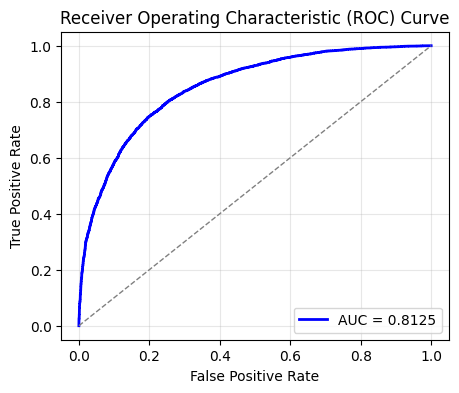

In [48]:
plot_auc(fpr, tpr, test_auc)

In [49]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


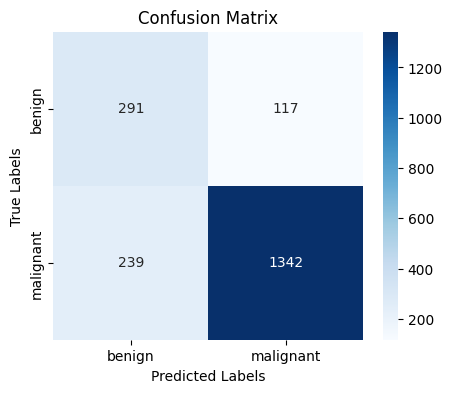

In [50]:
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])

resnet18

In [51]:
import torch.nn as nn
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
num_classes=2
log_interval = 10
l2_decay = 0.01
model = Resnet18(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'resnet18'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [02:03<00:00,  5.19batch/s]


train accuracy: 80.42967224121094%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9241

Test set: Average loss: 0.3303, Accuracy: 82.65%

Validation loss decreased (inf --> 0.330314). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [02:00<00:00,  5.29batch/s]


train accuracy: 84.92708587646484%
Specificity: 1.0000, Sensitivity: 0.0010, AUC: 0.9062

Test set: Average loss: 0.3898, Accuracy: 80.34%

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 639/639 [01:58<00:00,  5.38batch/s]


train accuracy: 84.83409881591797%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9046

Test set: Average loss: 0.4140, Accuracy: 80.09%

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 639/639 [01:59<00:00,  5.36batch/s]


train accuracy: 84.1196060180664%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9464

Test set: Average loss: 0.2968, Accuracy: 86.48%

Validation loss decreased (0.330314 --> 0.296822). Saving model...
Model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_4.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_epoch_4.pth

Epoch 6/50: 100%|██████████| 639/639 [02:00<00:00,  5.31batch/s]


train accuracy: 84.0315170288086%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8903

Test set: Average loss: 0.4190, Accuracy: 81.25%

EarlyStopping counter: 1 out of 20


Epoch 7/50: 100%|██████████| 639/639 [02:01<00:00,  5.24batch/s]


train accuracy: 84.00215148925781%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8458

Test set: Average loss: 0.4807, Accuracy: 73.10%

EarlyStopping counter: 2 out of 20


Epoch 8/50: 100%|██████████| 639/639 [01:59<00:00,  5.33batch/s]


train accuracy: 84.21748352050781%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.7344

Test set: Average loss: 0.6093, Accuracy: 65.71%

EarlyStopping counter: 3 out of 20


Epoch 9/50: 100%|██████████| 639/639 [01:59<00:00,  5.34batch/s]


train accuracy: 84.04619598388672%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8146

Test set: Average loss: 0.5180, Accuracy: 71.09%

EarlyStopping counter: 4 out of 20


Epoch 10/50: 100%|██████████| 639/639 [01:59<00:00,  5.37batch/s]


train accuracy: 84.20769500732422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9453

Test set: Average loss: 0.2932, Accuracy: 84.01%

Validation loss decreased (0.296822 --> 0.293198). Saving model...


Epoch 11/50: 100%|██████████| 639/639 [01:59<00:00,  5.36batch/s]


train accuracy: 89.26788330078125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9423

Test set: Average loss: 0.3122, Accuracy: 84.57%

EarlyStopping counter: 1 out of 20


Epoch 12/50: 100%|██████████| 639/639 [01:58<00:00,  5.39batch/s]


train accuracy: 91.3477554321289%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9228

Test set: Average loss: 0.3586, Accuracy: 82.20%

EarlyStopping counter: 2 out of 20


Epoch 13/50: 100%|██████████| 639/639 [01:58<00:00,  5.41batch/s]


train accuracy: 91.91543579101562%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9216

Test set: Average loss: 0.3813, Accuracy: 81.95%

EarlyStopping counter: 3 out of 20


Epoch 14/50: 100%|██████████| 639/639 [01:59<00:00,  5.36batch/s]


train accuracy: 92.6103515625%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9405

Test set: Average loss: 0.3138, Accuracy: 84.77%

EarlyStopping counter: 4 out of 20


Epoch 15/50: 100%|██████████| 639/639 [01:59<00:00,  5.36batch/s]


train accuracy: 93.25634002685547%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9407

Test set: Average loss: 0.3339, Accuracy: 84.06%

EarlyStopping counter: 5 out of 20


Epoch 16/50: 100%|██████████| 639/639 [02:00<00:00,  5.31batch/s]


train accuracy: 92.96270751953125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9367

Test set: Average loss: 0.3413, Accuracy: 84.72%

EarlyStopping counter: 6 out of 20


Epoch 17/50: 100%|██████████| 639/639 [02:01<00:00,  5.28batch/s]


train accuracy: 93.93167877197266%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9416

Test set: Average loss: 0.3274, Accuracy: 83.11%

EarlyStopping counter: 7 out of 20


Epoch 18/50: 100%|██████████| 639/639 [02:01<00:00,  5.27batch/s]


train accuracy: 93.85337829589844%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9296

Test set: Average loss: 0.3531, Accuracy: 83.71%

EarlyStopping counter: 8 out of 20


Epoch 19/50: 100%|██████████| 639/639 [02:01<00:00,  5.27batch/s]


train accuracy: 94.27424621582031%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9284

Test set: Average loss: 0.3677, Accuracy: 83.06%

EarlyStopping counter: 9 out of 20


Epoch 20/50: 100%|██████████| 639/639 [02:00<00:00,  5.32batch/s]


train accuracy: 94.11275482177734%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9289

Test set: Average loss: 0.3689, Accuracy: 83.56%

EarlyStopping counter: 10 out of 20


Epoch 21/50: 100%|██████████| 639/639 [01:59<00:00,  5.33batch/s]


train accuracy: 96.19261932373047%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9318

Test set: Average loss: 0.3760, Accuracy: 82.50%

EarlyStopping counter: 11 out of 20


Epoch 22/50: 100%|██████████| 639/639 [01:59<00:00,  5.35batch/s]


train accuracy: 96.8581771850586%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9336

Test set: Average loss: 0.3730, Accuracy: 83.71%

EarlyStopping counter: 12 out of 20


Epoch 23/50: 100%|██████████| 639/639 [02:00<00:00,  5.29batch/s]


train accuracy: 97.21542358398438%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9244

Test set: Average loss: 0.4045, Accuracy: 83.76%

EarlyStopping counter: 13 out of 20


Epoch 24/50: 100%|██████████| 639/639 [01:59<00:00,  5.36batch/s]


train accuracy: 97.4894790649414%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9219

Test set: Average loss: 0.4036, Accuracy: 83.76%

EarlyStopping counter: 14 out of 20


Epoch 25/50: 100%|██████████| 639/639 [02:03<00:00,  5.18batch/s]


train accuracy: 97.18606567382812%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9251

Test set: Average loss: 0.3964, Accuracy: 84.51%

EarlyStopping counter: 15 out of 20


Epoch 26/50: 100%|██████████| 639/639 [01:59<00:00,  5.35batch/s]


train accuracy: 97.38671112060547%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9304

Test set: Average loss: 0.3970, Accuracy: 84.01%

EarlyStopping counter: 16 out of 20


Epoch 27/50: 100%|██████████| 639/639 [01:55<00:00,  5.53batch/s]


train accuracy: 97.51884460449219%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9239

Test set: Average loss: 0.4098, Accuracy: 83.61%

EarlyStopping counter: 17 out of 20


Epoch 28/50: 100%|██████████| 639/639 [01:59<00:00,  5.35batch/s]


train accuracy: 97.46990203857422%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9136

Test set: Average loss: 0.4357, Accuracy: 83.16%

EarlyStopping counter: 18 out of 20


Epoch 29/50: 100%|██████████| 639/639 [01:57<00:00,  5.43batch/s]


train accuracy: 97.71949005126953%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9243

Test set: Average loss: 0.4153, Accuracy: 83.96%

EarlyStopping counter: 19 out of 20


Epoch 30/50: 100%|██████████| 639/639 [01:57<00:00,  5.42batch/s]


train accuracy: 97.8369369506836%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9330

Test set: Average loss: 0.3860, Accuracy: 85.02%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification/resnet18/resnet18_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification/resnet18/resnet18_final_epoch.pth

In [53]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [54]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.6433    0.4634    0.5387      1938
   malignant     0.8093    0.8986    0.8517      4913

    accuracy                         0.7755      6851
   macro avg     0.7263    0.6810    0.6952      6851
weighted avg     0.7624    0.7755    0.7631      6851


Confusion Matrix:
 [[ 898 1040]
 [ 498 4415]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8107

test set: Average loss: 0.6226, Accuracy: 5313/6851 (77.55%)



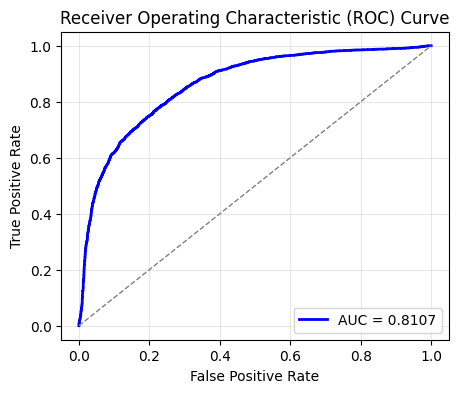

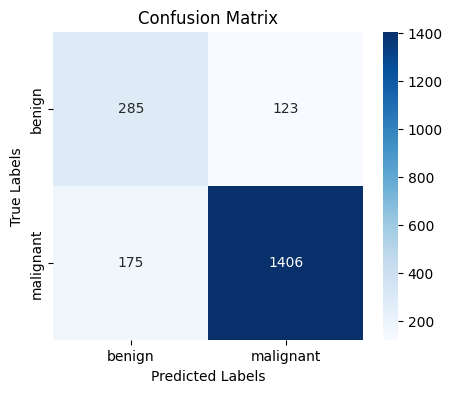

In [55]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   
plot_auc(fpr, tpr, test_auc)

import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])    

resnet 50

In [56]:
import torch
import torchvision.models as models

# For ResNet18
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()  # Set the model to evaluation mode
print("ResNet50 Model:")
print(resnet50)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1,

In [57]:
import torch

import torch.nn as nn

import torchvision.models as models

In [58]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.features = model_resnet50.fc.in_features
        self.fc = nn.Linear(self.features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [59]:
model = Resnet50()

print(model)

Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

next run 
1 early stop
2 train fun
3 val fun

In [60]:
import torch.nn as nn
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
num_classes=2
log_interval = 10
l2_decay = 0.01
#model = customVGG16(num_classes=num_classes)
model = Resnet50(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [61]:
import os
from IPython.display import FileLink

# Model training
model.to(device)  

best_accuracy = 0
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification_3'
model_name = 'resnet18'

# Set Kaggle working directory
os.chdir(r'/kaggle/working')

for epoch in range(1, total_epochs + 1):
    # Training step
    train(epoch, model, total_epochs, train_loader, criterion, l2_decay)

    # Validation step
    with torch.no_grad():
        test_loss, accuracy, cm, auc = validation(model, val_loader)

    # Handle model state for single/multiple GPUs
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Save directory for models
    model_save_dir = os.path.join('model', project_name, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping check
    early_stop(test_loss, model)

    # Save the best model based on AUC
    if auc > best_accuracy:
        best_accuracy = auc
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model_state_dict, model_save_path, _use_new_zipfile_serialization=False)
        print(f"Model saved at: {os.path.abspath(model_save_path)}")

        # Generate download link for Kaggle
        print("Generating download link for the saved model...")
        display(FileLink(model_save_path))

    # Stop training if early stopping is triggered
    if early_stop.early_stop:
        print("Early stopping")
        break

# Save the model at the final epoch if early stopping is triggered
final_model_save_path = os.path.join(model_save_dir, f'{model_name}_final_epoch.pth')
torch.save(model_state_dict, final_model_save_path, _use_new_zipfile_serialization=False)
print(f"Final model saved at: {os.path.abspath(final_model_save_path)}")

# Generate download link for the final model
print("Generating download link for the final model...")
display(FileLink(final_model_save_path))


Epoch 2/50: 100%|██████████| 639/639 [04:17<00:00,  2.49batch/s]


train accuracy: 78.72174072265625%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8050

Test set: Average loss: 0.5209, Accuracy: 68.43%

Validation loss decreased (inf --> 0.520949). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_1.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_1.pth

Epoch 3/50: 100%|██████████| 639/639 [04:15<00:00,  2.50batch/s]


train accuracy: 84.02661895751953%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8587

Test set: Average loss: 0.4631, Accuracy: 73.45%

Validation loss decreased (0.520949 --> 0.463060). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_2.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_2.pth

Epoch 4/50: 100%|██████████| 639/639 [04:17<00:00,  2.49batch/s]


train accuracy: 81.96143341064453%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.6257

Test set: Average loss: 0.6894, Accuracy: 57.47%

EarlyStopping counter: 1 out of 20


Epoch 5/50: 100%|██████████| 639/639 [04:19<00:00,  2.46batch/s]


train accuracy: 80.8701171875%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.7703

Test set: Average loss: 0.5569, Accuracy: 67.37%

EarlyStopping counter: 2 out of 20


Epoch 6/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 80.90927124023438%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.7868

Test set: Average loss: 0.5480, Accuracy: 70.69%

EarlyStopping counter: 3 out of 20


Epoch 7/50: 100%|██████████| 639/639 [04:15<00:00,  2.50batch/s]


train accuracy: 80.19966888427734%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.5514

Test set: Average loss: 0.8969, Accuracy: 56.41%

EarlyStopping counter: 4 out of 20


Epoch 8/50: 100%|██████████| 639/639 [04:16<00:00,  2.49batch/s]


train accuracy: 80.11157989501953%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.3777

Test set: Average loss: 0.8870, Accuracy: 35.60%

EarlyStopping counter: 5 out of 20


Epoch 9/50: 100%|██████████| 639/639 [04:17<00:00,  2.49batch/s]


train accuracy: 80.19477081298828%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9240

Test set: Average loss: 0.3580, Accuracy: 83.56%

Validation loss decreased (0.463060 --> 0.358004). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_8.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_8.pth

Epoch 10/50: 100%|██████████| 639/639 [04:19<00:00,  2.47batch/s]


train accuracy: 80.34648132324219%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.6675

Test set: Average loss: 0.6797, Accuracy: 62.29%

EarlyStopping counter: 1 out of 20


Epoch 11/50: 100%|██████████| 639/639 [04:16<00:00,  2.49batch/s]


train accuracy: 85.1179428100586%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9371

Test set: Average loss: 0.3193, Accuracy: 83.16%

Validation loss decreased (0.358004 --> 0.319300). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_10.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_10.pth

Epoch 12/50: 100%|██████████| 639/639 [04:16<00:00,  2.50batch/s]


train accuracy: 86.194580078125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9302

Test set: Average loss: 0.3357, Accuracy: 82.91%

EarlyStopping counter: 1 out of 20


Epoch 13/50: 100%|██████████| 639/639 [04:15<00:00,  2.50batch/s]


train accuracy: 86.6741714477539%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9408

Test set: Average loss: 0.3122, Accuracy: 84.82%

Validation loss decreased (0.319300 --> 0.312231). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_12.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_12.pth

Epoch 14/50: 100%|██████████| 639/639 [04:19<00:00,  2.47batch/s]


train accuracy: 86.84545135498047%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8804

Test set: Average loss: 0.4285, Accuracy: 77.38%

EarlyStopping counter: 1 out of 20


Epoch 15/50: 100%|██████████| 639/639 [04:17<00:00,  2.49batch/s]


train accuracy: 87.63335418701172%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9347

Test set: Average loss: 0.3265, Accuracy: 84.21%

EarlyStopping counter: 2 out of 20


Epoch 16/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 87.78995513916016%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9441

Test set: Average loss: 0.3036, Accuracy: 85.22%

Validation loss decreased (0.312231 --> 0.303606). Saving model...
Model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_15.pth
Generating download link for the saved model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_epoch_15.pth

Epoch 17/50: 100%|██████████| 639/639 [04:18<00:00,  2.47batch/s]


train accuracy: 87.64314270019531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9253

Test set: Average loss: 0.3541, Accuracy: 83.31%

EarlyStopping counter: 1 out of 20


Epoch 18/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 88.26465606689453%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9114

Test set: Average loss: 0.3832, Accuracy: 81.25%

EarlyStopping counter: 2 out of 20


Epoch 19/50: 100%|██████████| 639/639 [04:18<00:00,  2.47batch/s]


train accuracy: 88.39189910888672%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8789

Test set: Average loss: 0.4446, Accuracy: 77.33%

EarlyStopping counter: 3 out of 20


Epoch 20/50: 100%|██████████| 639/639 [04:21<00:00,  2.44batch/s]


train accuracy: 88.66105651855469%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.8802

Test set: Average loss: 0.4346, Accuracy: 77.48%

EarlyStopping counter: 4 out of 20


Epoch 21/50: 100%|██████████| 639/639 [04:20<00:00,  2.45batch/s]


train accuracy: 90.5892105102539%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9269

Test set: Average loss: 0.3523, Accuracy: 82.81%

EarlyStopping counter: 5 out of 20


Epoch 22/50: 100%|██████████| 639/639 [04:18<00:00,  2.47batch/s]


train accuracy: 91.02965545654297%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9319

Test set: Average loss: 0.3387, Accuracy: 83.41%

EarlyStopping counter: 6 out of 20


Epoch 23/50: 100%|██████████| 639/639 [04:22<00:00,  2.43batch/s]


train accuracy: 91.42115783691406%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9333

Test set: Average loss: 0.3376, Accuracy: 83.21%

EarlyStopping counter: 7 out of 20


Epoch 24/50: 100%|██████████| 639/639 [04:18<00:00,  2.47batch/s]


train accuracy: 91.46520233154297%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9222

Test set: Average loss: 0.3693, Accuracy: 82.45%

EarlyStopping counter: 8 out of 20


Epoch 25/50: 100%|██████████| 639/639 [04:19<00:00,  2.46batch/s]


train accuracy: 91.45052337646484%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9353

Test set: Average loss: 0.3341, Accuracy: 84.46%

EarlyStopping counter: 9 out of 20


Epoch 26/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 91.58265686035156%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9298

Test set: Average loss: 0.3570, Accuracy: 83.36%

EarlyStopping counter: 10 out of 20


Epoch 27/50: 100%|██████████| 639/639 [04:18<00:00,  2.48batch/s]


train accuracy: 92.09161376953125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9321

Test set: Average loss: 0.3476, Accuracy: 84.11%

EarlyStopping counter: 11 out of 20


Epoch 28/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 91.93990325927734%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9169

Test set: Average loss: 0.3960, Accuracy: 82.70%

EarlyStopping counter: 12 out of 20


Epoch 29/50: 100%|██████████| 639/639 [04:17<00:00,  2.48batch/s]


train accuracy: 92.33140563964844%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9236

Test set: Average loss: 0.3904, Accuracy: 83.06%

EarlyStopping counter: 13 out of 20


Epoch 30/50: 100%|██████████| 639/639 [04:16<00:00,  2.49batch/s]


train accuracy: 92.58588409423828%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9324

Test set: Average loss: 0.3455, Accuracy: 84.82%

EarlyStopping counter: 14 out of 20


Epoch 31/50: 100%|██████████| 639/639 [04:18<00:00,  2.48batch/s]


train accuracy: 92.84526062011719%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9300

Test set: Average loss: 0.3561, Accuracy: 84.36%

EarlyStopping counter: 15 out of 20


Epoch 32/50: 100%|██████████| 639/639 [04:17<00:00,  2.49batch/s]


train accuracy: 92.85993957519531%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9356

Test set: Average loss: 0.3408, Accuracy: 85.27%

EarlyStopping counter: 16 out of 20


Epoch 33/50: 100%|██████████| 639/639 [04:14<00:00,  2.51batch/s]


train accuracy: 92.97249603271484%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9272

Test set: Average loss: 0.3656, Accuracy: 84.26%

EarlyStopping counter: 17 out of 20


Epoch 34/50: 100%|██████████| 639/639 [04:13<00:00,  2.52batch/s]


train accuracy: 92.96270751953125%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9286

Test set: Average loss: 0.3610, Accuracy: 84.21%

EarlyStopping counter: 18 out of 20


Epoch 35/50: 100%|██████████| 639/639 [04:13<00:00,  2.52batch/s]


train accuracy: 92.85015106201172%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9305

Test set: Average loss: 0.3590, Accuracy: 84.67%

EarlyStopping counter: 19 out of 20


Epoch 36/50: 100%|██████████| 639/639 [04:15<00:00,  2.50batch/s]


train accuracy: 93.1095199584961%
Specificity: 1.0000, Sensitivity: 0.0005, AUC: 0.9265

Test set: Average loss: 0.3691, Accuracy: 83.96%

EarlyStopping counter: 20 out of 20
Early stopping
Final model saved at: /kaggle/working/model/tumor_classification_3/resnet18/resnet18_final_epoch.pth
Generating download link for the final model...


/kaggle/working/model/tumor_classification_3/resnet18/resnet18_final_epoch.pth

In [62]:
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve

import torch

import numpy as np

import torch.nn.functional as F



def test(model, test_loader):
    name = 'test'
    len_test_loader = len(test_loader.dataset)
    model.eval()

    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    true_labels = []  # Collect true labels here
    class_names = ['benign', 'malignant']

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.extend(pred.cpu().numpy())  # Collect predictions
        true_labels.extend(target.cpu().numpy())  # Collect true labels

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Ensure all_predictions and true_labels are flattened
    all_predictions = np.array(all_predictions)
    true_labels = np.array(true_labels)

    # Classification metrics -> accuracy, F1 score
    print(metrics.classification_report(true_labels, all_predictions, target_names=class_names, digits=4))

    # Confusion matrix
    cm = metrics.confusion_matrix(true_labels, all_predictions)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve and AUC
    num_classes = len(class_names)
    label_onehot = np.eye(num_classes)[true_labels.astype(int)]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    # Specificity, Sensitivity, AUC
    test_loss /= len_test_loader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len_test_loader, 100. * correct / len_test_loader))

    #return 100. * correct / len_test_loader, test_loss, auc_value
    return 100. * correct / len_test_loader, test_loss, auc_value, fpr, tpr



In [63]:
test_accuracy, test_loss, test_auc, fpr, tpr = test(model, test_loader)

              precision    recall  f1-score   support

      benign     0.5669    0.5072    0.5354      1938
   malignant     0.8134    0.8471    0.8299      4913

    accuracy                         0.7510      6851
   macro avg     0.6901    0.6772    0.6827      6851
weighted avg     0.7436    0.7510    0.7466      6851


Confusion Matrix:
 [[ 983  955]
 [ 751 4162]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.7850

test set: Average loss: 0.6431, Accuracy: 5145/6851 (75.10%)



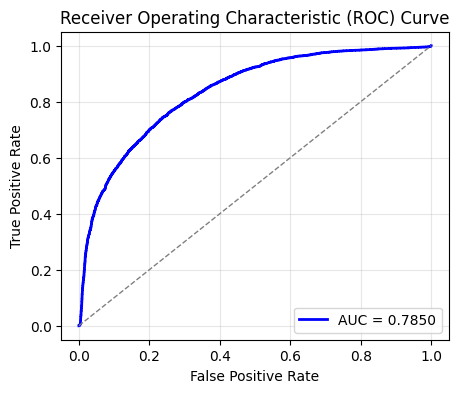

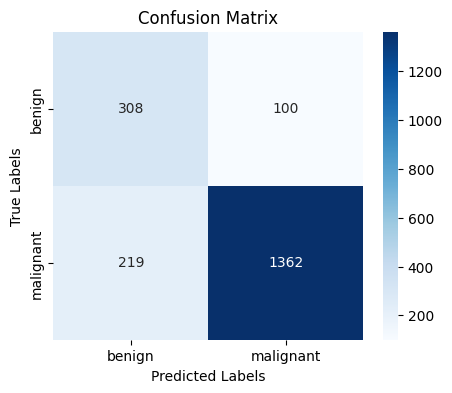

In [64]:
import matplotlib.pyplot as plt

def plot_auc(fpr, tpr, auc_value):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_value:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()   
plot_auc(fpr, tpr, test_auc)

import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(cm, class_names=['benign', 'malignant'])    